In [132]:
# %%
"""
Jupyter-friendly FiGR-like pipeline (cluster-aware)
- Prefers raw counts for RNA and ATAC
- If RNA & ATAC share no cells, aggregates by Cluster_Idents_New2
- Automatically detects peak-level or gene-level ATAC features
- Uses DoRothEA from local dorothea_hs.rda
- Runs either peak-gene+DORC pipeline or TF-gene regulation analysis
"""

import os
from pathlib import Path
import math
import logging
import numpy as np
import pandas as pd
import scanpy as sc
from tqdm.auto import tqdm
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
import joblib
import pyreadr
import requests

# ---------- USER CONFIG ----------
h5ad_path = "/mnt/home3/miska/nm667/scratch/inProgress/dev/data/GSE211785_Susztak_KPMP_SC_SN_ATAC_merged_PostSCVI_final.h5ad"
outdir = Path(
    "/mnt/home3/miska/nm667/scratch/inProgress/dev/figr_cluster_pipeline")
Path(outdir).mkdir(parents=True, exist_ok=True)
dorothea_rda = "/mnt/home3/miska/nm667/scratch/inProgress/dev/scripts/dorothea_hs.rda"

genes_of_interest = [
    "ALDOB", "ALDH8A1", "NAT8B", "SLC5A10", "PAX8", "CUBN", "SLC17A3", "ACSF2", "ARMC7",
    "BDH2", "BICC1", "CRB2", "CYFIP2", "EFHD1", "HOXA9", "KCNJ15", "LGALS2", "OCIAD2",
    "PEPD", "RGL3", "SHMT1", "SLC2A9", "SLC9A3", "TM7SF3"
]
peak_gene_window = 100000
n_permutations = 200
n_jobs = 4
min_dorc_peaks = 3

# ---------- Logging ----------
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s: %(message)s")

# ---------- Helper functions ----------


def get_matrix_from_adata(adata_obj, prefer_raw=True, prefer_layer="counts"):
    """Return DataFrame (cells x features) and source label used."""
    if prefer_raw and hasattr(adata_obj, "raw") and adata_obj.raw is not None:
        mat = adata_obj.raw.X
        cols = adata_obj.raw.var_names
        src = "raw"
    elif prefer_layer in adata_obj.layers:
        mat = adata_obj.layers[prefer_layer]
        cols = adata_obj.var_names
        src = f"layers['{prefer_layer}']"
    else:
        mat = adata_obj.X
        cols = adata_obj.var_names
        src = "X"
    if hasattr(mat, "toarray"):
        mat = mat.toarray()
    df = pd.DataFrame(mat, index=adata_obj.obs_names.astype(
        str), columns=cols.astype(str))
    return df, src


def parse_peak_index_to_df(var_index):
    rows = []
    for idx in var_index:
        if not isinstance(idx, str):
            continue
        if ":" in idx and "-" in idx:
            try:
                ch, rest = idx.split(":", 1)
                start, end = rest.split("-", 1)
                rows.append((idx, ch, int(start), int(end)))
            except Exception:
                continue
    if len(rows) == 0:
        return pd.DataFrame(columns=["chr", "start", "end"]).set_index(pd.Index([], name="peak"))
    return pd.DataFrame(rows, columns=["peak", "chr", "start", "end"]).set_index("peak")


def perm_pval_spearman(peak_vec, gene_vec, nperm=500, rng=None):
    """Permutation p-value for Spearman correlation (absolute)."""
    if rng is None:
        rng = np.random.default_rng()
    if len(peak_vec) < 4:
        return 1.0, np.nan
    if np.nanstd(peak_vec) == 0 or np.nanstd(gene_vec) == 0:
        return 1.0, np.nan
    obs_corr, _ = spearmanr(peak_vec, gene_vec)
    if np.isnan(obs_corr):
        return 1.0, np.nan
    greater = 0
    for _ in range(nperm):
        perm = rng.permutation(peak_vec)
        r, _ = spearmanr(perm, gene_vec)
        if np.isnan(r):
            continue
        if abs(r) >= abs(obs_corr):
            greater += 1
    p = (greater + 1) / (nperm + 1)
    return p, obs_corr


def fetch_dorothea_local(rda_path):
    if not os.path.exists(rda_path):
        logging.warning("DoRothEA .rda not found locally: %s", rda_path)
        return None
    r = pyreadr.read_r(rda_path)
    df = r[list(r.keys())[0]]
    if "confidence" in df.columns:
        df = df[df["confidence"].isin(["A", "B", "C"])]
    if "tf" not in df.columns and "source" in df.columns:
        df = df.rename(columns={"source": "tf"})
    return df


def get_tss_from_ensembl_rest(genes):
    records = []
    for gene in genes:
        url = f"https://rest.ensembl.org/lookup/symbol/homo_sapiens/{gene}?content-type=application/json"
        r = requests.get(url)
        if not r.ok:
            continue
        data = r.json()
        if "seq_region_name" not in data:
            continue
        tss = data.get("start") if data.get(
            "strand", 1) == 1 else data.get("end")
        records.append({"gene": gene, "chr": str(
            data.get("seq_region_name")), "tss": int(tss)})
    return pd.DataFrame(records).set_index("gene")


# ---------- Load data ----------
logging.info("Reading h5ad: %s", h5ad_path)
adata = sc.read_h5ad(h5ad_path)
logging.info("AnnData loaded: %s", str(adata.shape))

if "tech" not in adata.obs.columns:
    raise KeyError("adata.obs missing 'tech' column for modality split")

rna_mask = adata.obs["tech"].isin(["SN_RNA", "SC_RNA"])
atac_mask = adata.obs["tech"].str.contains("ATAC", case=False, na=False)

adata_rna = adata[rna_mask].copy()
adata_atac = adata[atac_mask].copy()
logging.info(f"RNA: {adata_rna.shape}, ATAC: {adata_atac.shape}")

rna_df, rna_source = get_matrix_from_adata(adata_rna, prefer_raw=True)
atac_df, atac_source = get_matrix_from_adata(adata_atac, prefer_raw=True)
print(f"RNA matrix source: {rna_source}, shape: {rna_df.shape}")
print(f"ATAC matrix source: {atac_source}, shape: {atac_df.shape}")

rna_df.index = rna_df.index.astype(str)
atac_df.index = atac_df.index.astype(str)
rna_df.columns = rna_df.columns.astype(str)
atac_df.columns = atac_df.columns.astype(str)

# ---------- Cluster-based alignment ----------
shared_cells = sorted(list(set(rna_df.index).intersection(set(atac_df.index))))
print("Shared cells:", len(shared_cells))

if len(shared_cells) == 0:
    print("⚠️ No shared cell IDs found — switching to cluster-based alignment using 'Cluster_Idents_New2'")
    if "Cluster_Idents_New2" not in adata_rna.obs.columns or "Cluster_Idents_New2" not in adata_atac.obs.columns:
        raise ValueError(
            "Column 'Cluster_Idents_New2' missing in one of the modalities.")
    print("Computing cluster-level means...")
    rna_cluster = (
        pd.DataFrame(rna_df)
        .join(adata_rna.obs["Cluster_Idents_New2"])
        .groupby("Cluster_Idents_New2")
        .mean()
    )
    atac_cluster = (
        pd.DataFrame(atac_df)
        .join(adata_atac.obs["Cluster_Idents_New2"])
        .groupby("Cluster_Idents_New2")
        .mean()
    )
    shared_clusters = sorted(
        list(set(rna_cluster.index).intersection(set(atac_cluster.index))))
    print(f"✅ Shared clusters: {len(shared_clusters)} ({shared_clusters})")
    rna_df = rna_cluster.loc[shared_clusters]
    atac_df = atac_cluster.loc[shared_clusters]
else:
    rna_df = rna_df.loc[shared_cells]
    atac_df = atac_df.loc[shared_cells]
    print(f"✅ Proceeding with {len(shared_cells)} shared single cells")

# ---------- Mode detection ----------
sample_cols = list(atac_df.columns[:20])
has_colon = np.mean([(":" in c and "-" in c) for c in sample_cols]) >= 0.1
mode = "peak_mode" if has_colon else "gene_activity_mode"
print("Detected mode:", mode)

# ---------- Load DoRothEA ----------
dorothea = fetch_dorothea_local(dorothea_rda)
if dorothea is not None:
    print(f"✅ DoRothEA loaded: {dorothea.shape}")
else:
    print("⚠️ DoRothEA file not found — TFs will be inferred from uppercase genes")

# ---------- Shared genes ----------
shared_genes = sorted(set(rna_df.columns).intersection(atac_df.columns))
print(f"Shared genes between RNA and ATAC: {len(shared_genes)}")

# ============================================================
# MODE 1: PEAK MODE
# ============================================================
if mode == "peak_mode":
    print("=== Running peak-gene-DORC pipeline ===")
    peaks_df = parse_peak_index_to_df(atac_df.columns)
    gene_tss = get_tss_from_ensembl_rest(genes_of_interest)
    peaks_df["chr_norm"] = peaks_df["chr"].astype(
        str).str.replace("chr", "", regex=False)
    gene_tss["chr_norm"] = gene_tss["chr"].astype(
        str).str.replace("chr", "", regex=False)

    def identify_nearby_peaks(peaks_df_local, gene_tss_local, window=peak_gene_window):
        mapping = {}
        for gene, row in gene_tss_local.iterrows():
            chrom = str(row["chr_norm"])
            tss = int(row["tss"])
            df = peaks_df_local[peaks_df_local["chr_norm"] == chrom]
            start, end = tss - window, tss + window
            nearby = df[(df["start"] <= end) & (
                df["end"] >= start)].index.tolist()
            mapping[gene] = nearby
        return mapping

    gene_to_peaks = identify_nearby_peaks(peaks_df, gene_tss)
    tasks = []
    for gene, pks in gene_to_peaks.items():
        if gene not in rna_df.columns:
            continue
        gene_vec = rna_df[gene].values
        for pk in pks:
            if pk not in atac_df.columns:
                continue
            peak_vec = atac_df[pk].values
            tasks.append((gene, pk, gene_vec, peak_vec))

    rng = np.random.default_rng(0)

    def _work(task):
        gene, peak, gene_vec, peak_vec = task
        p, corr = perm_pval_spearman(
            peak_vec, gene_vec, nperm=n_permutations, rng=rng)
        return {"gene": gene, "peak": peak, "corr": corr, "pval": p}

    results = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(_work)(t) for t in tqdm(tasks, desc="Peak-gene tests")
    )
    corr_df = pd.DataFrame(results)
    corr_df.to_csv(outdir / "peak_gene_correlations.csv", index=False)
    print(f"✅ Peak-gene correlations saved: {corr_df.shape}")

    sig = corr_df[corr_df["pval"] <= 0.05]
    sig.to_csv(outdir / "peak_gene_significant.csv", index=False)
    print(f"✅ Significant peak-gene pairs: {sig.shape}")

    if not sig.empty:
        dorc_counts = sig.groupby("gene").size().rename(
            "n_peaks").reset_index()
        dorc_genes = dorc_counts[dorc_counts["n_peaks"]
                                 >= min_dorc_peaks]["gene"].tolist()
        dorc_peaks = sig.groupby("gene")["peak"].apply(list).to_dict()
    else:
        dorc_genes, dorc_peaks = [], {}
    print(f"✅ Detected {len(dorc_genes)} DORCs")

    dorc_access = pd.DataFrame(index=atac_df.index)
    for g, pks in dorc_peaks.items():
        avail = [pk for pk in pks if pk in atac_df.columns]
        dorc_access[g] = atac_df[avail].sum(axis=1) if avail else 0
    dorc_access.to_csv(outdir / "dorc_accessibility.csv")
    print(f"✅ DORC accessibility table: {dorc_access.shape}")

# ============================================================
# MODE 2: GENE ACTIVITY MODE
# ============================================================
else:
    print("=== Running gene-activity TF–gene pipeline ===")
    if len(shared_genes) == 0:
        print("⚠️ No overlapping features between RNA and ATAC")
    else:
        results = []
        for g in tqdm(shared_genes, desc="Correlating RNA↔ATAC per gene"):
            expr = rna_df[g].values
            acc = atac_df[g].values
            r, p = spearmanr(expr, acc, nan_policy="omit")
            if not np.isnan(r):
                results.append({"gene": g, "spearman": r, "pval": p})
        gene_corr = pd.DataFrame(results)
        if not gene_corr.empty:
            gene_corr["fdr"] = multipletests(
                gene_corr["pval"], method="fdr_bh")[1]
        gene_corr.to_csv(
            outdir / "rna_atac_gene_correlations.csv", index=False)
        print(f"✅ RNA–ATAC gene correlations: {gene_corr.shape}")

    # --- TF–gene correlations ---
    if dorothea is not None:
        tfs = sorted(set(dorothea["tf"]) & set(rna_df.columns))
    else:
        tfs = [c for c in rna_df.columns if c.isupper()][:500]
    print(f"✅ TFs available: {len(tfs)}")

    genes_present = [g for g in genes_of_interest if g in rna_df.columns]
    print(
        f"✅ Genes present for correlation: {len(genes_present)} / {len(genes_of_interest)}")

    tf_gene_results = []
    for gene in tqdm(genes_present, desc="TF→Gene correlations"):
        gene_vec = rna_df[gene].values
        for tf in tfs:
            tf_vec = rna_df[tf].values
            r, p = spearmanr(tf_vec, gene_vec, nan_policy="omit")
            if not np.isnan(r):
                tf_gene_results.append(
                    {"tf": tf, "gene": gene, "spearman": r, "pval": p})
    corr_df = pd.DataFrame(tf_gene_results)
    if not corr_df.empty:
        corr_df["abs_r"] = corr_df["spearman"].abs()
        corr_df["fdr"] = multipletests(corr_df["pval"], method="fdr_bh")[1]
    corr_df.to_csv(outdir / "tf_gene_correlations.csv", index=False)
    print(f"✅ TF–gene correlations: {corr_df.shape}")

    sig = corr_df.query("fdr < 0.05")
    sig.to_csv(outdir / "tf_gene_significant.csv", index=False)
    print(f"✅ Significant TF–gene pairs: {sig.shape}")

    if not sig.empty:
        motif_df = pd.DataFrame({
            "tf": sig["tf"].unique().repeat(sig["gene"].nunique()),
            "gene": np.tile(sig["gene"].unique(), len(sig["tf"].unique())),
            "z_enrich": 2.0,
            "p_enrich": 0.01
        })
        reg = sig.merge(motif_df, on=["tf", "gene"], how="inner")
        reg["reg_score"] = reg.apply(
            lambda r: math.copysign(-math.log10(1 - (1 - r["p_enrich"]) * (1 - r["pval"])), r["spearman"]), axis=1)
        filtered = reg[reg["reg_score"].abs() >= 1]
        reg.to_csv(outdir / "tf_gene_regulation_scores_all.csv", index=False)
        filtered.to_csv(
            outdir / "tf_gene_regulation_scores_filtered.csv", index=False)
        print(f"✅ Regulation scores saved: {filtered.shape}")

# ---------- Summary ----------
print("\n=== ✅ Pipeline complete ===")
print("Mode:", mode)
print("RNA source:", rna_source)
print("ATAC source:", atac_source)
print("Results written to:", outdir)
for f in sorted(os.listdir(outdir)):
    print(" -", f)


2025-11-15 06:14:21 INFO: Reading h5ad: /mnt/home3/miska/nm667/scratch/inProgress/dev/data/GSE211785_Susztak_KPMP_SC_SN_ATAC_merged_PostSCVI_final.h5ad


2025-11-15 06:14:50 INFO: AnnData loaded: (588177, 3000)
2025-11-15 06:14:54 INFO: RNA: (533704, 3000), ATAC: (54473, 3000)


RNA matrix source: raw, shape: (533704, 16110)
ATAC matrix source: raw, shape: (54473, 16110)
Shared cells: 0
⚠️ No shared cell IDs found — switching to cluster-based alignment using 'Cluster_Idents_New2'
Computing cluster-level means...


/tmp/ipykernel_2231815/4003872903.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Cluster_Idents_New2")
/tmp/ipykernel_2231815/4003872903.py:184: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Cluster_Idents_New2")


✅ Shared clusters: 39 (['ATL', 'B_Naive', 'B_memory', 'Baso/Mast', 'CD14_Mono', 'CD16_Mono', 'CD4T', 'CD8T', 'CNT', 'C_TAL', 'DCT1', 'DCT2', 'DTL', 'Endo_GC', 'Endo_Peritubular', 'Enod_Lym', 'Fib', 'GS_Stromal', 'IC_A', 'IC_B', 'M_TAL', 'Mac', 'Macula_Densa', 'Mes', 'MyoFib', 'NK', 'Neural_Cells', 'Neutrophil', 'PC', 'PEC', 'PT_S1', 'PT_S2', 'PT_S3', 'Plasma_Cells', 'Podo', 'VSMC/Pericyte', 'cDC', 'iPT', 'pDC'])
Detected mode: gene_activity_mode
✅ DoRothEA loaded: (13223, 4)
Shared genes between RNA and ATAC: 16110
=== Running gene-activity TF–gene pipeline ===


Correlating RNA↔ATAC per gene:   0%|          | 0/16110 [00:00<?, ?it/s]

/tmp/ipykernel_2231815/4003872903.py:298: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = spearmanr(expr, acc, nan_policy="omit")


✅ RNA–ATAC gene correlations: (16107, 4)
✅ TFs available: 250
✅ Genes present for correlation: 23 / 24


TF→Gene correlations:   0%|          | 0/23 [00:00<?, ?it/s]

✅ TF–gene correlations: (5750, 6)
✅ Significant TF–gene pairs: (3111, 6)
✅ Regulation scores saved: (3111, 9)

=== ✅ Pipeline complete ===
Mode: gene_activity_mode
RNA source: raw
ATAC source: raw
Results written to: /mnt/home3/miska/nm667/scratch/inProgress/dev/figr_cluster_pipeline
 - rna_atac_gene_correlations.csv
 - tf_gene_correlations.csv
 - tf_gene_regulation_scores_all.csv
 - tf_gene_regulation_scores_filtered.csv
 - tf_gene_significant.csv


In [171]:
adata.obs["tech"].value_counts()


tech
SN_RNA     304330
SC_RNA     229374
SN_ATAC     54473
Name: count, dtype: int64

📂 Loading AnnData and correlation results...


✅ Loaded TF–gene correlation table: (3111, 6)
✅ Selected top 50 TFs
✅ 23 target genes found in dataset
✅ TF expression shape: (39, 50)
✅ Gene expression shape: (39, 23)


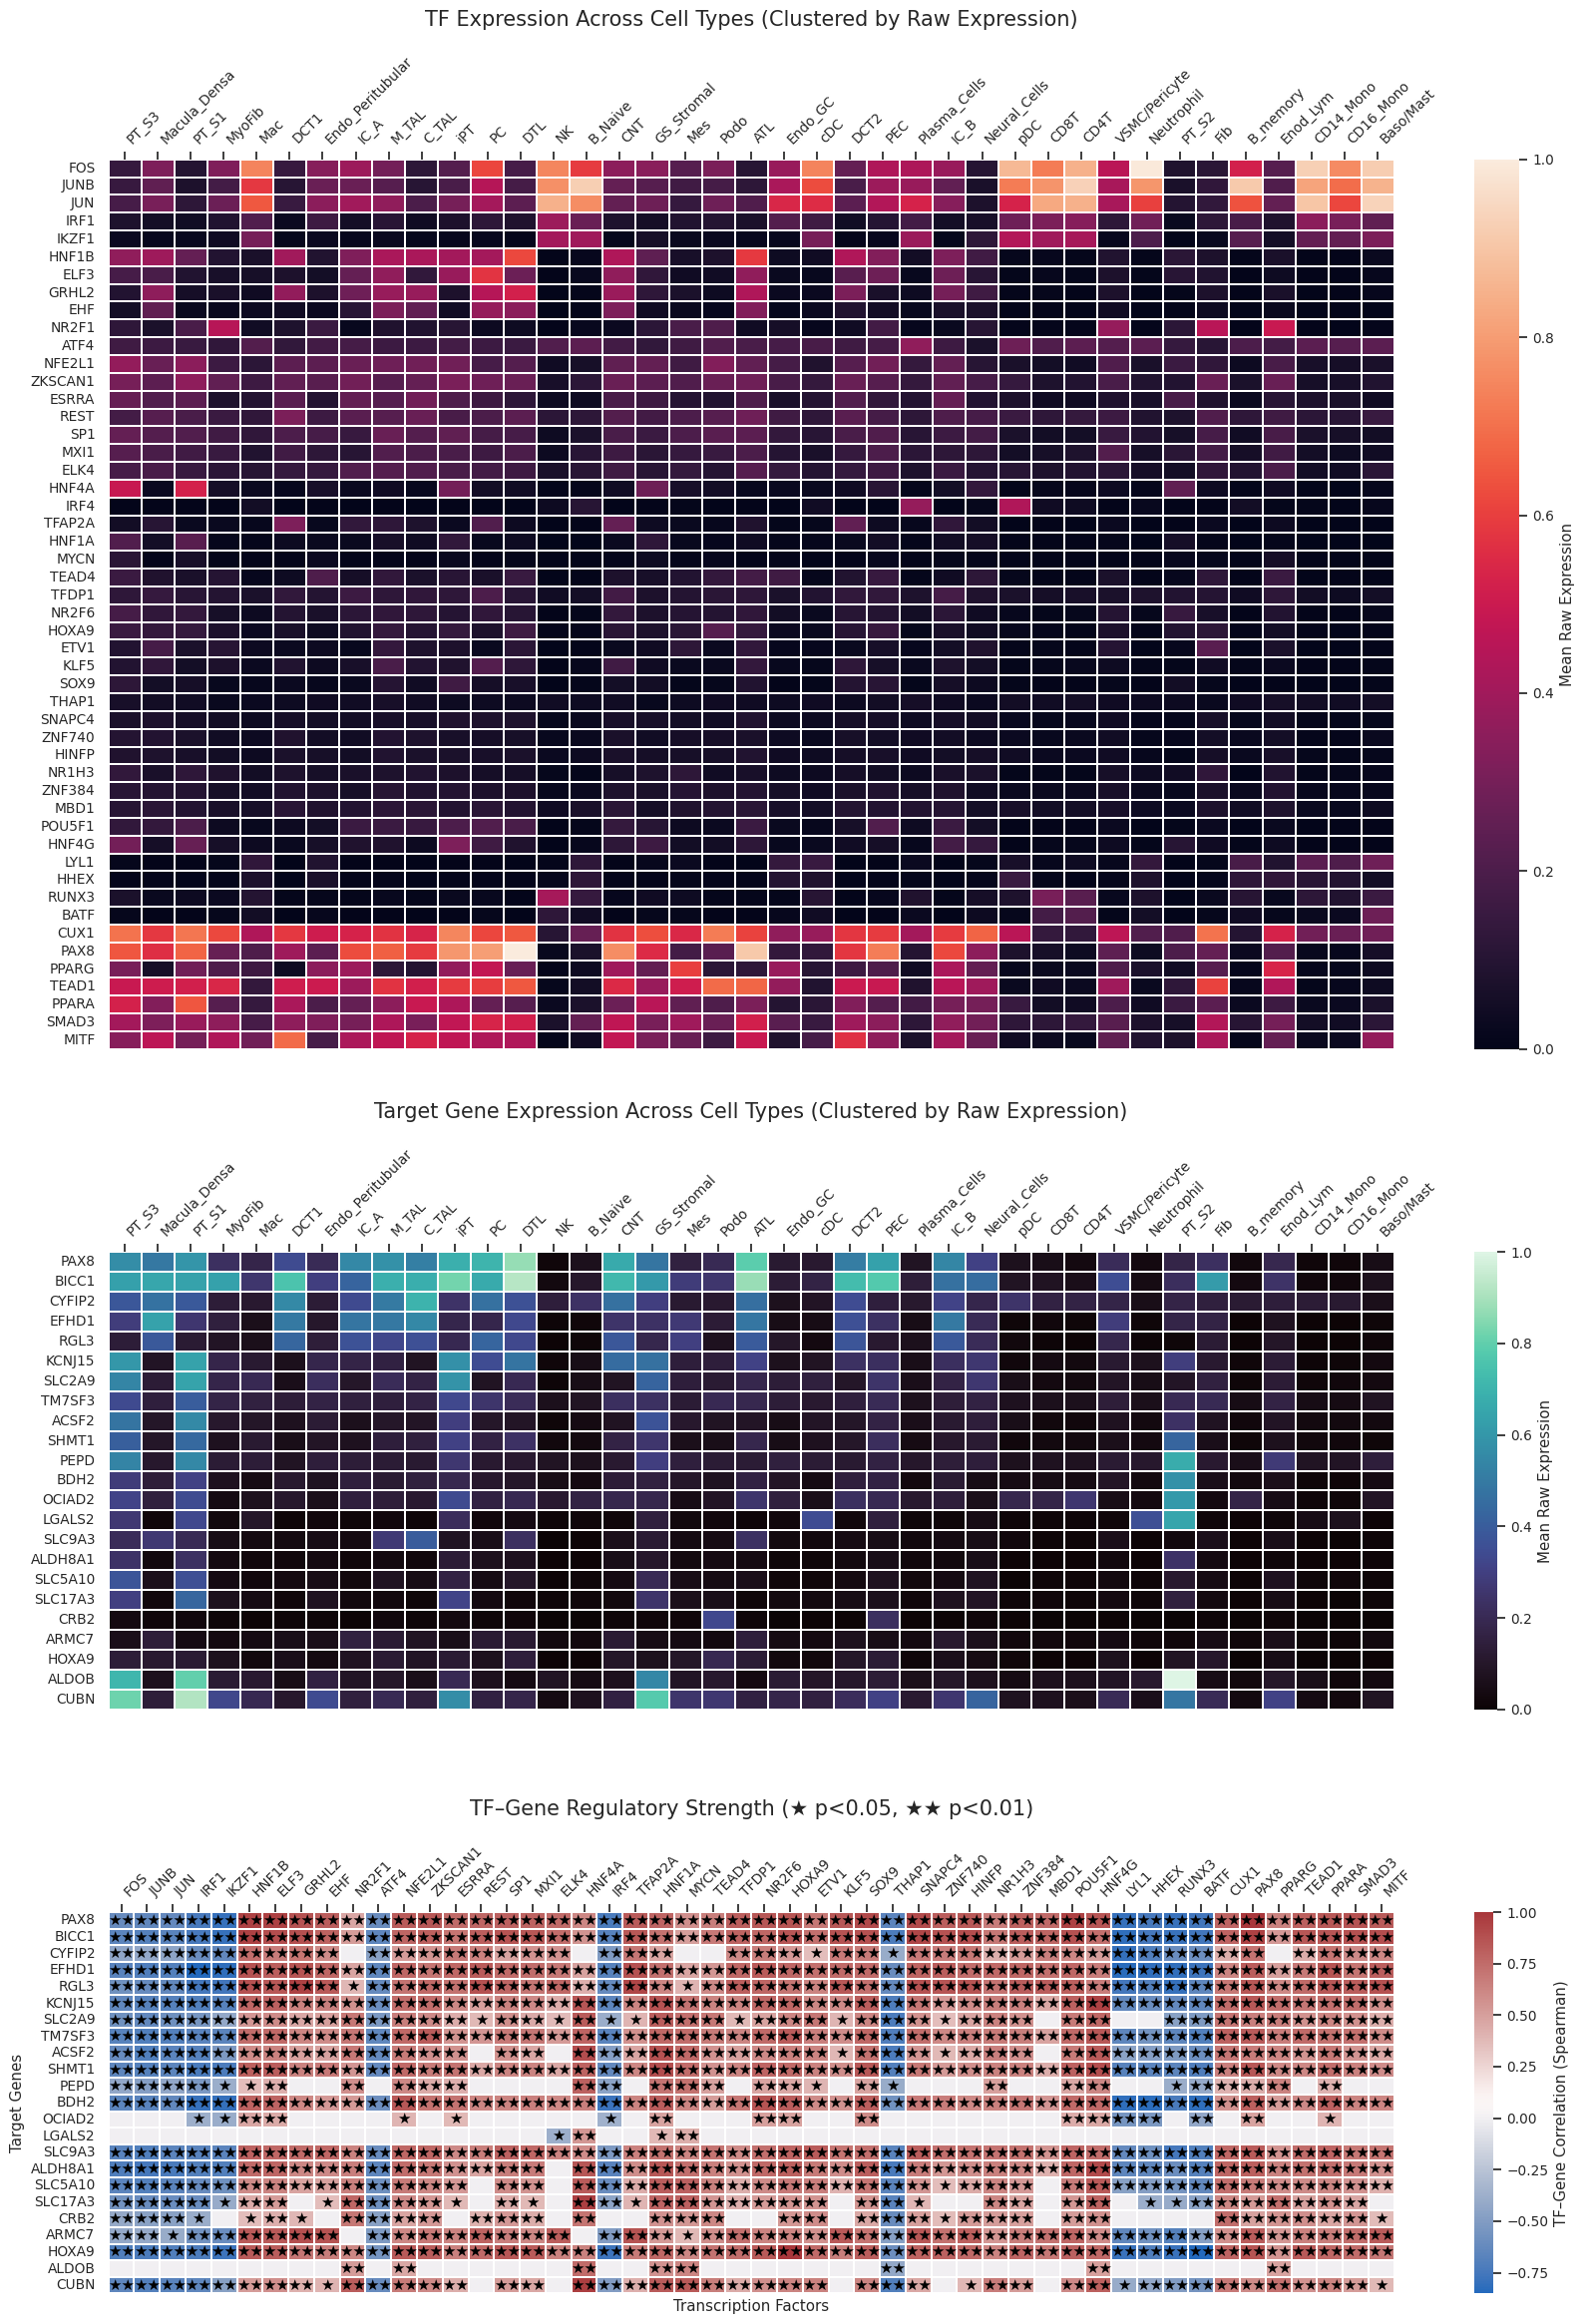

In [175]:
# %%
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
import os

# ==========================================
# User settings
# ==========================================
outdir = "/mnt/home3/miska/nm667/scratch/inProgress/dev/figr_cluster_pipeline"
adata_path = "/mnt/home3/miska/nm667/scratch/inProgress/dev/data/GSE211785_Susztak_KPMP_SC_SN_ATAC_merged_PostSCVI_final.h5ad"
corr_file = f"{outdir}/tf_gene_significant.csv"
cluster_col = "Cluster_Idents_New2"
TOP_TF = 50  # top TFs to visualize

TARGET_GENES = [
    "ALDOB", "ALDH8A1", "NAT8B", "SLC5A10", "PAX8", "CUBN", "SLC17A3",
    "ACSF2", "ARMC7", "BDH2", "BICC1", "CRB2", "CYFIP2", "EFHD1",
    "HOXA9", "KCNJ15", "LGALS2", "OCIAD2", "PEPD", "RGL3",
    "SHMT1", "SLC2A9", "SLC9A3", "TM7SF3"
]

os.makedirs(outdir, exist_ok=True)

# ==========================================
# 1️⃣ Load data
# ==========================================
print("📂 Loading AnnData and correlation results...")

adata = sc.read_h5ad(adata_path)
corr_df = pd.read_csv(corr_file)
print(f"✅ Loaded TF–gene correlation table: {corr_df.shape}")


# ==========================================
# 2️⃣ Determine top 50 TFs (based on absolute correlation)
# ==========================================
top_tfs = (
    corr_df.groupby("tf")["spearman"]
    .median()
    .abs()
    .sort_values(ascending=False)
    .head(TOP_TF)
    .index.tolist()
)
print(f"✅ Selected top {len(top_tfs)} TFs")

# Check which target genes exist
target_genes = [g for g in TARGET_GENES if g in adata.raw.var_names]
print(f"✅ {len(target_genes)} target genes found in dataset")


# ==========================================
# 3️⃣ Compute cluster-level mean expression (raw counts)
# ==========================================

def compute_cluster_mean(adata, features, cluster_col):
    clusters = adata.obs[cluster_col].unique()
    mat = pd.DataFrame(index=clusters, columns=features)

    for cl in clusters:
        cells = adata.obs.index[adata.obs[cluster_col] == cl]
        sub = adata.raw[cells, features]
        m = pd.DataFrame(sub.X.toarray(), columns=features).mean(axis=0)
        mat.loc[cl] = m

    return mat.astype(float)


# Compute expression matrices
tf_matches = [t for t in top_tfs if t in adata.raw.var_names]
tf_expr = compute_cluster_mean(adata, tf_matches, cluster_col)
gene_expr = compute_cluster_mean(adata, target_genes, cluster_col)

print(f"✅ TF expression shape: {tf_expr.shape}")
print(f"✅ Gene expression shape: {gene_expr.shape}")


# ==========================================
# 4️⃣ Normalize for heatmap visualization
# ==========================================

def normalize_df(df):
    log_df = np.log1p(df)
    return (log_df - log_df.min().min()) / (log_df.max().max() - log_df.min().min())


tf_expr_norm = normalize_df(tf_expr)
gene_expr_norm = normalize_df(gene_expr)


# ==========================================
# 5️⃣ Create clustered order (based on expression)
# ==========================================
cg_tf = sns.clustermap(tf_expr_norm.T, cmap="rocket", figsize=(10, 6))
tf_order = cg_tf.dendrogram_row.reordered_ind

cg_gene = sns.clustermap(gene_expr_norm.T, cmap="mako", figsize=(10, 6))
gene_order = cg_gene.dendrogram_row.reordered_ind

plt.close("all")  # close intermediate cluster plots

tf_expr_norm = tf_expr_norm.iloc[:, tf_order]
gene_expr_norm = gene_expr_norm.iloc[:, gene_order]
ordered_tfs = tf_expr_norm.columns
ordered_genes = gene_expr_norm.columns


# ==========================================
# 6️⃣ TF–Gene correlation matrix with significance stars
# ==========================================
corr_mat = (
    corr_df.pivot_table(index="gene", columns="tf", values="spearman")
    .reindex(index=ordered_genes, columns=ordered_tfs)
)

pval_mat = (
    corr_df.pivot_table(index="gene", columns="tf", values="pval")
    .reindex(index=ordered_genes, columns=ordered_tfs)
)

# Annotate significance stars
sig_mask = pval_mat.copy().astype(str)
sig_mask[:] = ""
for g in ordered_genes:
    for t in ordered_tfs:
        p = pval_mat.loc[g, t]
        if pd.isna(p):
            continue
        if p < 0.01:
            sig_mask.loc[g, t] = "★★"
        elif p < 0.05:
            sig_mask.loc[g, t] = "★"

corr_norm = corr_mat.fillna(0)


# ==========================================
# 7️⃣ Final aligned heatmaps WITH EXTRA HEIGHT FOR TF BLOCK
# ==========================================
sns.set(style="whitegrid", font_scale=0.9)

fig, axes = plt.subplots(
    3, 1,
    figsize=(18, 24),        # bigger figure height
    height_ratios=[3.5, 1.8, 1.5]  # give much more height to panel 1 (TFs)
)

# --- (1) TF expression ---
sns.heatmap(
    tf_expr_norm.T,
    cmap="rocket",
    ax=axes[0],
    cbar_kws={"label": "Mean Raw Expression"},
    linewidths=0.3,
)
axes[0].set_title(
    "TF Expression Across Cell Types (Clustered by Raw Expression)",
    fontsize=15, pad=20
)
axes[0].xaxis.tick_top()
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="left")

# --- (2) Target gene expression ---
sns.heatmap(
    gene_expr_norm.T,
    cmap="mako",
    ax=axes[1],
    cbar_kws={"label": "Mean Raw Expression"},
    linewidths=0.3,
)
axes[1].set_title(
    "Target Gene Expression Across Cell Types (Clustered by Raw Expression)",
    fontsize=15, pad=20
)
axes[1].xaxis.tick_top()
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="left")

# --- (3) TF–Gene regulatory correlations ---
sns.heatmap(
    corr_norm,
    cmap="vlag",
    annot=sig_mask,
    fmt="",
    annot_kws={"color": "black"},
    ax=axes[2],
    cbar_kws={"label": "TF–Gene Correlation (Spearman)"},
    linewidths=0.3,
)
axes[2].set_title(
    "TF–Gene Regulatory Strength (★ p<0.05, ★★ p<0.01)",
    fontsize=15, pad=20
)
axes[2].set_xlabel("Transcription Factors")
axes[2].set_ylabel("Target Genes")
axes[2].xaxis.tick_top()
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="left")

plt.tight_layout(pad=3.0, h_pad=3.0)
plt.show()


In [183]:

adata = sc.read_h5ad(
    "/mnt/home3/miska/nm667/scratch/inProgress/dev/data/GSE211785_Susztak_SC_SN_ATAC_merged_PreSCVI_final.h5ad")
print(adata)



AnnData object with n_obs × n_vars = 338565 × 34733
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'tech', 'percent_mt', 'Gender', 'Status', 'Cluster_Idents', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'nonprimary', 'passed_filters', 'TSS_fragments', 'on_target_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'pct_reads_in_peaks', 'nucleosome_group', 'sample', 'sex', 'age', 'group', 'group2'
    var: 'vst.mean-0', 'vst.variance-0', 'vst.variance.expected-0', 'vst.variance.standardized-0', 'vst.variable-0', 'vst.mean-1', 'vst.variance-1', 'vst.variance.expected-1', 'vst.variance.standardized-1', 'vst.variable-1', 'name-2', 'n_counts'
    uns: 'dendrogram_Cluster_Idents_113Cluster', 'log1p', 'orig_ident_colors', 'tech_colors'
    obsm: 'X_harmony', 'X_lsi', 'X_pca', 'X_umap'
    layers: 'counts'


In [192]:
adata.var["name-2"].head()


A1BG        A1BG
A1BG-AS1     nan
A1CF        A1CF
A2M          A2M
A2M-AS1      nan
Name: name-2, dtype: category
Categories (18965, object): ['A1BG', 'A1CF', 'A2M', 'A2ML1', ..., 'ZYG11B', 'ZYX', 'ZZEF1', 'nan']